## Extract data from followed-by trigger language files
Files with trigger laguage are located in \\\\legal.regn.net\DAY\Shares\Themis\GoldenFTraining\HasTriggerLanguage
<br/>
Files that have no trigger language are located in \\\\legal.regn.net\DAY\Shares\Themis\GoldenFTraining\NoTriggerLanguage
<br/>

In [1]:
import glob
tl_files = glob.glob(r'\\legal.regn.net\DAY\Shares\Themis\GoldenFTraining\HasTriggerLanguage\*.xml')
nt_files = glob.glob(r'\\legal.regn.net\DAY\Shares\Themis\GoldenFTraining\NoTriggerLanguage\*.xml')

### Use regex to find top level paragraph and trigger elements 
It is expensive to create DOM for the entire document as some documents may not have trigger language. The approach is to break the document into top level paragraph text fragments and then locate trigger language in each fragment. If trigger language is located, DOM is created for the paragraph fragment.

In [2]:
import re

trigger = re.compile(r'(<laaa:treatmentTrigger.*</laaa:treatmentTrigger>)')

def find_trigger(s):  
    '''Find trigger elements in given text fragment'''
    return trigger.findall(s)

paragph = re.compile(r'(<lnvxe:text>.*?</lnvxe:text>)')

def find_paragph(s): 
    '''Find top level paragraph elements in given text fragment'''
    return paragph.findall(s)

### Encode editor id

In [4]:
editor_alias = '@'

editors = {}

def get_editor_alias(editor_id):
  if not editors.get(editor_id, ''):
        global editor_alias
        editor_alias = chr(ord(editor_alias) + 1)
        editors[editor_id] = editor_alias
  return editors[editor_id]

### Parse document using lxml etree

In [65]:
from lxml import etree as ElementTree


def xml_to_tree(fragment):
    '''Return ElementTree for given xml text'''
    namespaces = {'laaa':'http://www.w3.org/laaa', 'lnci':'http://www.w3.org/lnci', 'lnvxe':'http://www.w3.org/lnvxe' }
    ns = ' '.join(('xmlns:{}="{}"'.format(*i) for i in namespaces.items()))
    xml = '<doc {}>{}</doc>'.format(ns, fragment)
    tree = ElementTree.fromstring(xml)
    return tree, namespaces


def find_element_attributes(tag, attr, value, fragment):
    '''
    Return attribute list of the first element based on tag and attribute value.
    '''
    tree, namespaces = xml_to_tree(fragment)
    elements = tree.xpath(".//{}[@{}='{}']".format(tag, attr, value), namespaces=namespaces)
    attributes = elements[0].attrib if elements else []
    return attributes

def find_descendants(tag, tree, namespaces):
    '''
    Return descendant elements based on tag and attribute value.
    '''
    elements = tree.xpath(".//{}".format(tag), namespaces=namespaces)
    return elements


def embedded_cite(id, fragment):
    '''Return True if given text contains a lnci:cite element with ID attribute = id'''
    attributes = find_element_attributes('lnci:cite', 'ID', id, fragment)
    return True if attributes else False


def find_cite_references(fragment):
    '''Return list of cite id referenced by treatment trigger in given xml text'''
    tree, namespaces = xml_to_tree(fragment)
    elements = tree.findall('.//laaa:treatmentTriggerCiteReference', namespaces=namespaces)
    references = [e.attrib['ID'] for e in elements]
    return references


def find_case_references(fragment):
    '''Return list of case reference id in given xml text'''
    tree, namespaces = xml_to_tree(fragment)
    elements = tree.findall('.//lnci:caseref', namespaces=namespaces)
    references = [e.attrib['ID'] for e in elements]
    return references


def find_cites(fragment):
    '''Return list of tuples (cite_id, treatment_letter, is_anaphoric_ref) in given xml text'''
    def cite_letter(elements):
        letters = [e.attrib['letter'] for e in elements]
        return letters[0] if letters else None
    def anaphoric_ref(element):
        anaphref = element.attrib.get('anaphref')
        return anaphref
    tree, namespaces = xml_to_tree(fragment)
    elements = tree.xpath('.//lnci:cite', namespaces=namespaces)
    anapr = [anaphoric_ref(e) for e in elements]
    lettr = [cite_letter(find_descendants('lnci:editletter', e, namespaces)) for e in elements]
    cites = [e.attrib['ID'] for e in elements]
    return list(zip(cites, lettr, anapr))


def find_trigger_section(fragment):
    '''
    Return top level laaa:treatmentTrigger xml content as a string
    laaa:treatmentTrigger can have nested laaa:treatmentTrigger elements, return only top level elements.
    Nested laaa:treatmentTrigger has laaa:treatmentTriggerText as parent.
    ElementTree.tostring(...) returns trailing text after the end tag, so use regex to clean the xml string.
    '''
    if not find_trigger(fragment):
        return []
    tree, namespaces = xml_to_tree(fragment)
    elements = tree.xpath('.//laaa:treatmentTrigger', namespaces=namespaces)
    trigger_text_tag = '{http://www.w3.org/laaa}treatmentTriggerText'
    elements = [e for e in elements if e.xpath('..')[0].tag != trigger_text_tag]
    sections = [ElementTree.tostring(e, method='xml', encoding='utf-8').decode() for e in elements]
    sections = [find_trigger(s)[0] for s in sections]
    return sections


def find_trigger_language(fragment):
    '''
    Return all the text embedded within laaa:treatmentTriggerText elements in given laaa:treatmentTrigger xml string 
    '''
    namespaces = {'laaa':'http://www.w3.org/laaa', 'lnci':'http://www.w3.org/lnci', 'lnvxe':'http://www.w3.org/lnvxe' }
    parser = ElementTree.XMLParser(recover=True)
    root = ElementTree.fromstring(fragment, parser)
    elements = root.findall('.//', namespaces)
    trigger_elements = [e for e in elements if e.tag == '{http://www.w3.org/laaa}treatmentTriggerText']
    language = ''.join(trigger_elements[0].itertext())
    group_id = root.attrib['groupIdentifier']
    fragment_id = root.attrib['fragmentNumber']
    editor_id = root.attrib['editorId']
    return language, group_id, fragment_id, get_editor_alias(editor_id)


def get_text(fragment):
    '''Return all the text within given xml string'''
    tree, namespaces = xml_to_tree(fragment)
    return ''.join(tree.itertext())

### Description of DataFrame Columns 

<table style="float:left">
        <tr>
            <th style="text-align:left;">Name</td>
            <th style="text-align:left;">Description</td>
        </tr>
        <tr>
            <td style="text-align:left;">para_element</td>
            <td style="text-align:left;">xml with root element &lt;lnvxe:text&gt;</td>
        </tr>
        <tr>
            <td style="text-align:left;">para_text</td>
            <td style="text-align:left;">paragraph text</td>
        </tr>
        <tr>
            <td style="text-align:left;">trgr_element</td>
            <td style="text-align:left;">xml with root element &lt;laaa:treatmentTrigger&gt;</td>
        </tr>
        <tr>
            <td style="text-align:left;">trgr_language</td>
            <td style="text-align:left;">text contained in element &lt;laaa:treatmentTrigger&gt;</td>
        </tr>
        <tr>
            <td style="text-align:left;">cnt_cite_in_para</td>
            <td style="text-align:left;">number of &lt;lnci:cite&gt; elements within para_element</td>
        </tr>
        <tr>
            <td style="text-align:left;">cnt_cite_in_para_anaphref</td>
            <td style="text-align:left;">number of &lt;lnci:cite&gt; elements within para_element that have anaphref attribute</td>
        </tr>
        <tr>
            <td style="text-align:left;">cnt_f_letter_cite_in_para</td>
            <td style="text-align:left;">number of &lt;lnci:cite&gt; elements within para_element that have letter f</td>
        </tr>
        <tr>
            <td style="text-align:left;">cnt_nonf_letter_cite_in_para</td>
            <td style="text-align:left;">number of &lt;lnci:cite&gt; elements within para_element that have treatment letter other than f</td>
        </tr>        
        <tr>
            <td style="text-align:left;">cnt_cite_referenced</td>
            <td style="text-align:left;">number of &lt;laaa:treatmentTriggerCiteReference&gt; elements within &lt;laaa:treatmentTrigger&gt;</td>
        </tr>
        <tr>
            <td style="text-align:left;">cnt_cite_referenced_in_para</td>
            <td style="text-align:left;">number of &lt;lnci:cite&gt; elements within para_element that have been referenced using &lt;laaa:treatmentTriggerCiteReference&gt; elements</td>
        </tr>
        <tr>
            <td style="text-align:left;">cites_in_para</td>
            <td style="text-align:left;">cite reference list: [(Cite ID, letter)]</td>
        </tr>

</table>




### Process trigger files 
Capture cite information and trigger language details per paragraph

In [66]:
import os
import pandas as pd  

trigger_language_dict_metadata = ['para_text', 
                                  'trgr_element', 
                                  'trgr_language', 
                                  'group_id', 
                                  'fragment_id', 
                                  'editor_id',
                                  'cites_in_para',
                                  'cnt_cite_in_para',
                                  'cnt_cite_in_para_anaphref',
                                  'cnt_f_letter_cite_in_para', 
                                  'cnt_nonf_letter_cite_in_para',  
                                  'cnt_cite_referenced',
                                  'cnt_cite_referenced_in_para']

def make_trigger_language_dict(filename, para, para_id, **kwargs):
    '''Utility function to make a dictionary object for trigger language'''
    trigger_language_dict = {'filename': filename, 'para_element': para, 'para_id': para_id}
    for key, value in kwargs.items():
        if key not in trigger_language_dict_metadata:
            raise ValueError('unknown key {}'.format(key))
        trigger_language_dict[key] = value
    return trigger_language_dict


trigger_language_list = []

followed_letters = ['#&ff', '#ff', '&ff', 'ff', '#&f', '#f', '&f', 'f']

def f_letter(text):
    return False if not text else text in followed_letters

def nonf_letter(text):
    return False if not text else text not in followed_letters
    
def process_trigger_sections(file, para, para_id, trgrs):
    '''
    Create dictionary for each section that has trigger language
    and append to list
    '''
    for trgr in trgrs:
        para_text = get_text(para)
        language, group_id, fragment_id, editor_id = find_trigger_language(trgr)
        cites_in_para = find_cites(para)
        cnt_cite_in_para = len(cites_in_para)
        cnt_cite_in_para_anaphref = len([e for e in cites_in_para if e[2]])
        cnt_f_letter_cite_in_para = len([e for e in cites_in_para if f_letter(e[1])])
        cnt_nonf_letter_cite_in_para = len([e for e in cites_in_para if nonf_letter(e[1])])
        cite_ids_in_para = [c[0] for c in cites_in_para]
        cite_references = find_cite_references(trgr)
        cnt_cite_referenced = len(cite_references)
        cnt_cite_referenced_in_para = len([e for e in cite_references if e in cite_ids_in_para])
        trigger_language_dict = make_trigger_language_dict(file, para, para_id,
            para_text=para_text, 
            trgr_element=trgr, 
            trgr_language=language, 
            group_id=group_id, 
            fragment_id=fragment_id, 
            editor_id=editor_id,                                                           
            cites_in_para=cites_in_para,
            cnt_cite_in_para=cnt_cite_in_para,
            cnt_cite_in_para_anaphref=cnt_cite_in_para_anaphref,
            cnt_f_letter_cite_in_para=cnt_f_letter_cite_in_para,
            cnt_nonf_letter_cite_in_para=cnt_nonf_letter_cite_in_para,
            cnt_cite_referenced_in_para=cnt_cite_referenced_in_para,                                               
            cnt_cite_referenced=cnt_cite_referenced
        )
        trigger_language_list.append(trigger_language_dict)

        
def process_notrigger_para(file, para, para_id):
    '''
    Create dictionary when no no trigger language is present
    and append to list
    '''
    para_text = get_text(para)
    cites_in_para = find_cites(para)
    cnt_cite_in_para = len(cites_in_para)
    cnt_cite_in_para_anaphref = len([e for e in cites_in_para if e[2]])
    cnt_f_letter_cite_in_para = len([e for e in cites_in_para if f_letter(e[1]) ])
    cnt_nonf_letter_cite_in_para = len([e for e in cites_in_para if nonf_letter(e[1]) ])
    trigger_language_dict = make_trigger_language_dict(file, para, para_id,
        para_text=para_text,                                               
        trgr_element='', 
        trgr_language='', 
        group_id='', 
        fragment_id='', 
        editor_id='',             
        cites_in_para=cites_in_para,
        cnt_cite_in_para=cnt_cite_in_para,
        cnt_cite_in_para_anaphref=cnt_cite_in_para_anaphref,
        cnt_f_letter_cite_in_para=cnt_f_letter_cite_in_para,
        cnt_nonf_letter_cite_in_para=cnt_nonf_letter_cite_in_para,
        cnt_cite_referenced_in_para=0,                                               
        cnt_cite_referenced=0
    )
    trigger_language_list.append(trigger_language_dict)
    
    
def extract_trigger_language(file, content):
    '''Find trigger language in given content and process it'''
    for index, para in enumerate(find_paragph(content)):
        trgrs = find_trigger_section(para)
        if trgrs:
            process_trigger_sections(file, para, index, trgrs)
        else:
            process_notrigger_para(file, para, index)

for file in tl_files:
    f = open(file, "r", encoding="utf-8")
    content = f.read()
    try:
        extract_trigger_language(os.path.basename(f.name), content)
        print(os.path.basename(f.name), 'xml ok', sep=':')
    except Exception as e:
        print(os.path.basename(f.name), 'xml error', e, sep=':')
    f.close()

BL00116347.XML:xml ok
BL00211658.XML:xml ok
BL00267826.XML:xml ok
BL00915946.XML:xml ok
BL01194808.XML:xml ok
BL01258106.XML:xml ok
BL01258142.XML:xml ok
BL01258203.XML:xml ok
BL01262550.XML:xml ok
BL01310123.XML:xml ok
BL01386915.XML:xml ok
BL01408914.XML:xml ok
BL01415548.XML:xml ok
BL01424111.XML:xml ok
BL01428689.XML:xml ok
BL01430546.XML:xml ok
BL01430577.XML:xml ok
BL01430637.XML:xml ok
BL01442880.XML:xml ok
BL01477755.XML:xml ok
BL01480982.XML:xml ok
BL01496348.XML:xml ok
BL01496908.XML:xml ok
BL01505881.XML:xml ok
BL01516274.XML:xml ok
BL01516294.XML:xml ok
BL01517770.XML:xml ok
BL01521475.XML:xml ok
BL01565589.XML:xml ok
BL01601333.XML:xml ok
BL01606670.XML:xml ok
BL01612883.XML:xml ok
BL01616462.XML:xml ok
BL01623459.XML:xml ok
BL01637917.XML:xml ok
BL01649135.XML:xml ok
BL01649136.XML:xml ok
BL01652458.XML:xml ok
BL01652508.XML:xml ok
BL01664387.XML:xml ok
BL01666283.XML:xml ok
BL01667541.XML:xml ok
BL01668506.XML:xml ok
BL01670195.XML:xml ok
BL01670210.XML:xml ok
BL01671094

BL03554084.XML:xml ok
BL03562067.XML:xml ok
BL03565229.XML:xml ok
BL03569511.XML:xml ok
BL03580493.XML:xml ok
BL03583379.XML:xml ok
BL03583493.XML:xml ok
BL03583510.XML:xml ok
BL03583670.XML:xml ok
BL03586113.XML:xml ok
BL03586132.XML:xml ok
BL03589602.XML:xml ok
BL03589657.XML:xml ok
BL03589665.XML:xml ok
BL03589666.XML:xml ok
BL03589891.XML:xml ok
BL03595685.XML:xml ok
BL03597851.XML:xml ok
BL03597902.XML:xml ok
BL03598250.XML:xml ok
BL03598896.XML:xml ok
BL03603066.XML:xml ok
BL03608769.XML:xml ok
BL03622322.XML:xml ok
BL03632269.XML:xml ok
BL03634057.XML:xml ok
BL03637185.XML:xml ok
BL03638350.XML:xml ok
BL03643642.XML:xml ok
BL03644502.XML:xml ok
BL03645022.XML:xml ok
BL03645115.XML:xml ok
BL03645290.XML:xml ok
BL03645375.XML:xml ok
BL03645795.XML:xml ok
BL03645821.XML:xml ok
BL03648792.XML:xml ok
BL03648801.XML:xml ok
BL03652542.XML:xml ok
BL03652555.XML:xml ok
BL03652557.XML:xml ok
BL03652566.XML:xml ok
BL03652601.XML:xml ok
BL03652635.XML:xml ok
BL03652638.XML:xml ok
BL03653589

BL06516808.XML:xml ok
BL06522397.XML:xml ok
BL06553936.XML:xml ok
BL06553940.XML:xml ok
BL06555018.XML:xml ok
BL06557412.XML:xml ok
BL06557699.XML:xml ok
BL06557731.XML:xml ok
BL06572676.XML:xml ok
BL06574447.XML:xml ok
BL06582539.XML:xml ok
BL06620105.XML:xml ok
BL06662816.XML:xml ok
BL06678484.XML:xml ok
BL06678489.XML:xml ok
BL06679690.XML:xml ok
BL06684721.XML:xml ok
BL06684727.XML:xml ok
BL06684729.XML:xml ok
BL06686487.XML:xml ok
BL06688744.XML:xml ok
BL06688818.XML:xml ok
BL06690212.XML:xml ok
BL06693681.XML:xml ok
BL06694703.XML:xml ok
BL06694715.XML:xml ok
BL06694722.XML:xml ok
BL06694745.XML:xml ok
BL06694749.XML:xml ok
BL06695028.XML:xml ok
BL06697901.XML:xml ok
BL06697919.XML:xml ok
BL06697925.XML:xml ok
BL06701769.XML:xml ok
BL06732669.XML:xml ok
BL06734619.XML:xml ok
BL06734781.XML:xml ok
BL06735265.XML:xml ok
BL06735375.XML:xml ok
BL06739570.XML:xml ok
BL06763810.XML:xml ok
BL06768451.XML:xml ok
BL06769908.XML:xml ok
BL06771227.XML:xml ok
BL06773544.XML:xml ok
BL06774233

### Create a DataFrame with file data

In [67]:
pd.set_option('max_colwidth', 80)

trigger_language_rows = []

def convert_trigger_language():
    for item in trigger_language_list:        
        row = [item['filename'], 
               item['para_id'], 
               item['para_element'], 
               item['para_text'], 
               item['trgr_element'],                
               item['trgr_language'], 
               item['group_id'], 
               item['fragment_id'], 
               item['editor_id'],                
               item['cites_in_para'], 
               item['cnt_cite_in_para'], 
               item['cnt_cite_in_para_anaphref'], 
               item['cnt_f_letter_cite_in_para'], 
               item['cnt_nonf_letter_cite_in_para'], 
               item['cnt_cite_referenced'],
               item['cnt_cite_referenced_in_para']]
        trigger_language_rows.append(row)

convert_trigger_language()

columns = ['filename', 
           'para_id', 
           'para_element', 
           'para_text', 
           'trgr_element', 
           'trgr_language', 
           'group_id', 
           'fragment_id', 
           'editor_id', 
           'cites_in_para',
           'cnt_cite_in_para', 
           'cnt_cite_in_para_anaphref', 
           'cnt_f_letter_cite_in_para', 
           'cnt_nonf_letter_cite_in_para',
           'cnt_cite_referenced',
           'cnt_cite_referenced_in_para']

df = pd.DataFrame(trigger_language_rows, columns = columns, dtype = int) 
df 

filename  para_id  \
0                                       BL00116347.XML        0   
1                                       BL00116347.XML        1   
2                                       BL00116347.XML        2   
3                                       BL00116347.XML        3   
4                                       BL00116347.XML        4   
5                                       BL00116347.XML        5   
6                                       BL00116347.XML        6   
7                                       BL00116347.XML        7   
8                                       BL00116347.XML        8   
9                                       BL00116347.XML        9   
10                                      BL00116347.XML       10   
11                                      BL00116347.XML       11   
12                                      BL00116347.XML       12   
13                                      BL00116347.XML       13   
14                                      BL00116347.XML       14   
15                                      BL00116347.XML       15   
16                                      BL00116347.XML       16   
17                                      BL00116347.XML       17   
18                                      BL00116347.XML       18   
19                                      BL00116347.XML       19   
20                                      BL00116347.XML       20   
21                                      BL00116347.XML       21   
22                                      BL00116347.XML       22   
23                                      BL00116347.XML       23   
24                                      BL00116347.XML       24   
25                                      BL00116347.XML       25   
26                                      BL00116347.XML       26   
27                                      BL00116347.XML       27   
28                                      BL00116347.XML       28   
29                                      BL00211658.XML        0   
...                                                ...      ...   
55894  BR28090_5W12-SHK1-F4W2-60BP-00000-00_MERGED.XML       61   
55895  BR28090_5W12-SHK1-F4W2-60BP-00000-00_MERGED.XML       62   
55896  BR28090_5W12-SHK1-F4W2-60BP-00000-00_MERGED.XML       63   
55897  BR28090_5W12-SHK1-F4W2-60BP-00000-00_MERGED.XML       64   
55898  BR28090_5W12-SHK1-F4W2-60BP-00000-00_MERGED.XML       65   
55899  BR28090_5W12-SHK1-F4W2-60BP-00000-00_MERGED.XML       66   
55900  BR28090_5W12-SHK1-F4W2-60BP-00000-00_MERGED.XML       67   
55901  BR28090_5W12-SHK1-F4W2-60BP-00000-00_MERGED.XML       68   
55902  BR28090_5W12-SHK1-F4W2-60BP-00000-00_MERGED.XML       69   
55903  BR28090_5W12-SHK1-F4W2-60BP-00000-00_MERGED.XML       70   
55904  BR28090_5W12-SHK1-F4W2-60BP-00000-00_MERGED.XML       71   
55905  BR28090_5W12-SHK1-F4W2-60BP-00000-00_MERGED.XML       72   
55906  BR28090_5W12-SHK1-F4W2-60BP-00000-00_MERGED.XML       72   
55907  BR28090_5W12-SHK1-F4W2-60BP-00000-00_MERGED.XML       73   
55908  BR28090_5W12-SHK1-F4W2-60BP-00000-00_MERGED.XML       74   
55909  BR28090_5W12-SHK1-F4W2-60BP-00000-00_MERGED.XML       75   
55910  BR28090_5W12-SHK1-F4W2-60BP-00000-00_MERGED.XML       76   
55911  BR28090_5W12-SHK1-F4W2-60BP-00000-00_MERGED.XML       77   
55912  BR28090_5W12-SHK1-F4W2-60BP-00000-00_MERGED.XML       78   
55913  BR28090_5W12-SHK1-F4W2-60BP-00000-00_MERGED.XML       79   
55914  BR28090_5W12-SHK1-F4W2-60BP-00000-00_MERGED.XML       80   
55915  BR28090_5W12-SHK1-F4W2-60BP-00000-00_MERGED.XML       81   
55916  BR28090_5W12-SHK1-F4W2-60BP-00000-00_MERGED.XML       82   
55917  BR28090_5W12-SHK1-F4W2-60BP-00000-00_MERGED.XML       83   
55918  BR28090_5W12-SHK1-F4W2-60BP-00000-00_MERGED.XML       84   
55919  BR28090_5W12-SHK1-F4W2-60BP-00000-00_MERGED.XML       85   
55920  BR28090_5W12-SHK1-F4W2-60BP-00000-00_MERGED.XML       86   
55921  BR28090_5W12-SHK1-F4W2-60BP-00000-00_MERGED.XML       87   
55922  BR28090_5W12-SHK1-F

### Plot Number of Documents with Treatment vs No Treatment

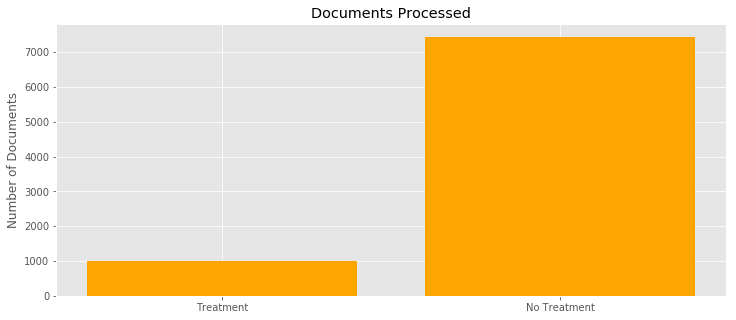

In [145]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

x = ['Treatment', 'No Treatment']
documents = [len(tl_files), len(nt_files)]

x_pos = [i for i, _ in enumerate(x)]

plt.bar(x_pos, documents, color='orange')
plt.ylabel("Number of Documents")
plt.title("Documents Processed")

fig = plt.gcf()
fig.set_size_inches(12,5)

plt.xticks(x_pos, x)

plt.show()

### Distribution of Trigger Language
A document consists of multiple paragraphs represented by &lt;lnvxe:text&gt; element. Trigger language may span multiple paragraphs. To capture trigger language across multiple paragraphs, a group identifier is used to bundle treatment language fragments - e.g. BL01666283.XML

<laaa:treatmentTrigger groupIdentifier="I7SGF01" guid="I5KS01" totalFragments="2" fragmentNumber="1">

There may also be instances when multiple fragments may appear within a &lt;lnvxe:text&gt; element - e.g. BL01258142.XML

A given document may have more than one group of trigger language.

Text(0.5, 1.0, 'Distribution of Trigger Language Groups')

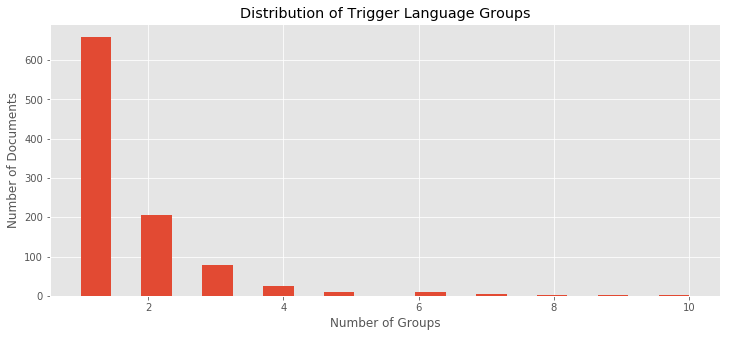

In [138]:
df_group = df.query('trgr_language != ""').groupby(['filename'])['group_id'].agg('nunique').to_frame('group_count')
hist = df_group.hist(column="group_count", bins=20, figsize=(12,5))
hist[0][0].set_ylabel('Number of Documents')
hist[0][0].set_xlabel('Number of Groups')
hist[0][0].set_title('Distribution of Trigger Language Groups')

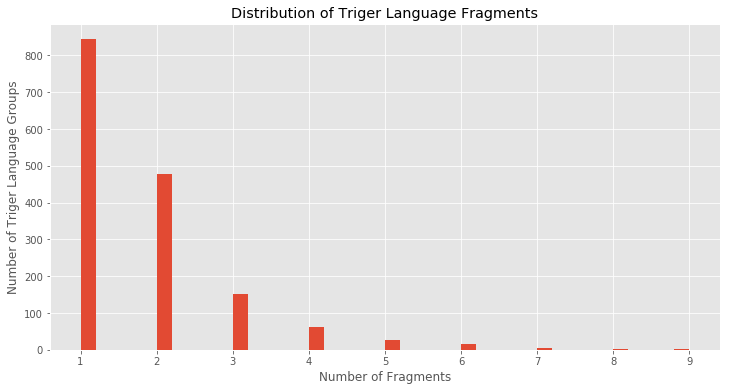

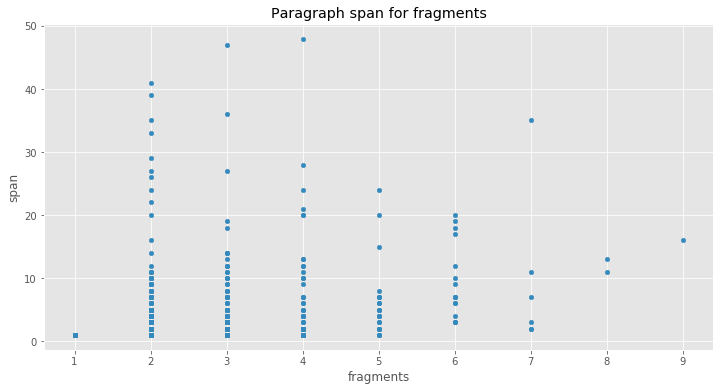

In [137]:
df_group = df.query('trgr_language != ""').groupby(['group_id'])['fragment_id'].agg('max').to_frame('fragment_count').astype('float64')
hist = df_group.hist(column="fragment_count", bins=40, figsize=(12,6))
hist[0][0].set_ylabel('Number of Triger Language Groups')
hist[0][0].set_xlabel('Number of Fragments')
hist[0][0].set_title('Distribution of Triger Language Fragments')

df0 = df.query('group_id != ""').groupby(['group_id'])['para_id'].agg('min').astype(float).to_frame('para_min').reset_index()
df1 = df.query('group_id != ""').groupby(['group_id'])['para_id'].agg('max').astype(float).to_frame('para_max').reset_index()
df2 = df.query('group_id != ""').groupby(['group_id'])['fragment_id'].agg('max').astype(float).to_frame('fragments').reset_index()
df_span = df0
df_span['para_max'] = df1['para_max']
df_span['span'] = df_span['para_max'] - df_span['para_min'] + 1
df_span['fragments'] = df2['fragments'].astype(float)
df_span.plot.scatter(x='fragments', y='span', title="Paragraph span for fragments", figsize=(12,6));

Text(0.5, 1.0, 'Distribution of Trigger Language Size ')

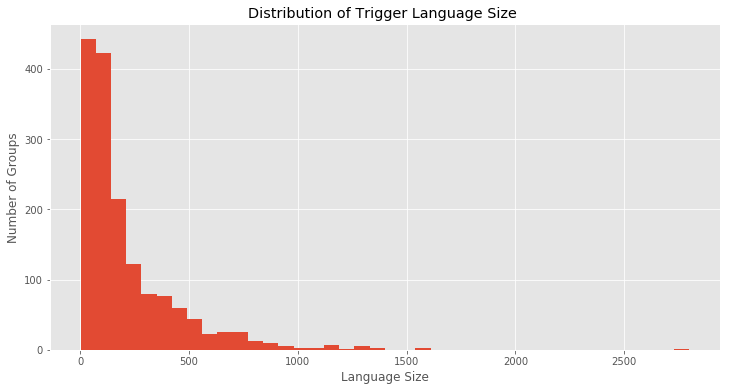

In [71]:
trgr_data = pd.DataFrame(df.query('trgr_language != ""'))
trgr_data["language_size"] = trgr_data["trgr_language"].str.len()
size_data = trgr_data.groupby(['group_id'])['language_size'].agg('sum').to_frame('language_size')
hist = size_data.hist(column="language_size", bins=40, figsize=(12,6))
hist[0][0].set_ylabel('Number of Groups')
hist[0][0].set_xlabel('Language Size')
hist[0][0].set_title('Distribution of Trigger Language Size ')

### Distribution of Trigger Language by Editor
Graphs below depict statistics on language size and number of documents processed by each editor

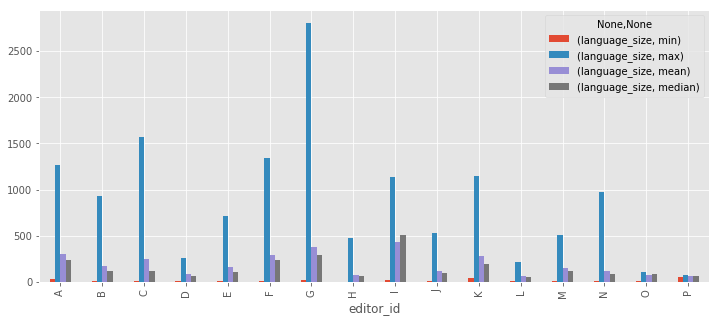

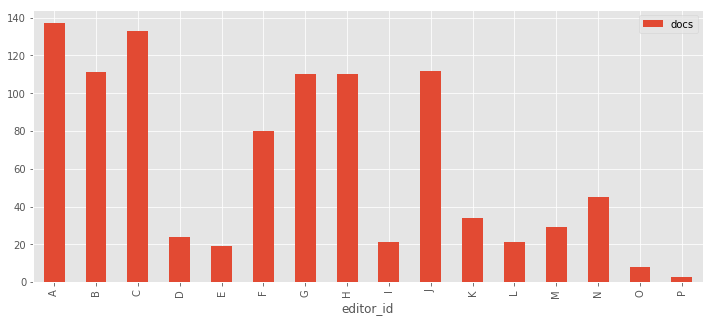

In [72]:
trgr_data = pd.DataFrame(df.query('trgr_language != ""'))
trgr_data["language_size"] = trgr_data["trgr_language"].str.len()
lang_data = trgr_data[['editor_id','language_size', 'group_id']]
size_data = lang_data.groupby(['group_id'])['language_size'].agg('sum').to_frame('language_size')
editor_data = lang_data.groupby(['group_id'])['editor_id'].agg('max').to_frame('editor_id')
editor_data['language_size'] = size_data['language_size']
editor_data = editor_data.reset_index().drop(columns=['group_id']).groupby(['editor_id']).agg(['min','max', 'mean', 'median'])
editor_data.plot.bar(figsize=(12,5))
doc_data = trgr_data.groupby(['filename'])['editor_id'].agg('max').to_frame().groupby(['editor_id']).size().to_frame('docs')
doc_data.plot.bar(figsize=(12,5))

### Ditribution of followed by cites in a document
Some documents have more than 1 citations that are treated with letter 'f'. For example BL01505881.XML has 6 citations that have been followed:

- Mielo v. Steak &apos;n Shake Operations, Inc.
- Hayes v. Wal-Mart Stores, Inc.
- Marcus v. BMW of N. Am., LLC
- In re Modafinil Antitrust Litig.
- Dewey v. Volkswagen Aktiengesellschaft
- In re Modafinil Antitrust Litig.

Some document with trigger language have no followed by citations and this is attributed to letter not being captured for referenced cites (user error?) e.g. BL01262550.XML

Text(0.5, 1.0, 'Distribution of FollowedBy Cites ')

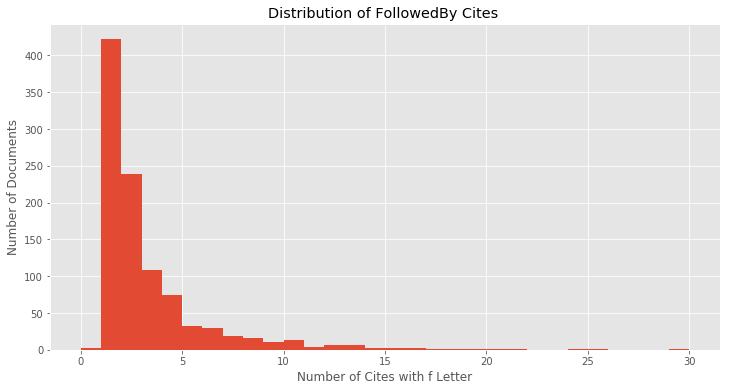

In [93]:
df_group = df.groupby(['filename'])['cnt_f_letter_cite_in_para'].agg('sum').to_frame('cites_with_f_letter')
hist = df_group.hist(column="cites_with_f_letter", bins=30, figsize=(12,6))
hist[0][0].set_ylabel('Number of Documents')
hist[0][0].set_xlabel('Number of Cites with f Letter')
hist[0][0].set_title('Distribution of FollowedBy Cites ')

### Ditribution of followed by cites outside paragraphs with trigger language
Some citations with followed by letter appear outside of paragraphs that have trigger language e.g. BL01258142.XML

Text(0.5, 1.0, 'Distribution of FollowedBy Cites outside paragraphs with trigger language ')

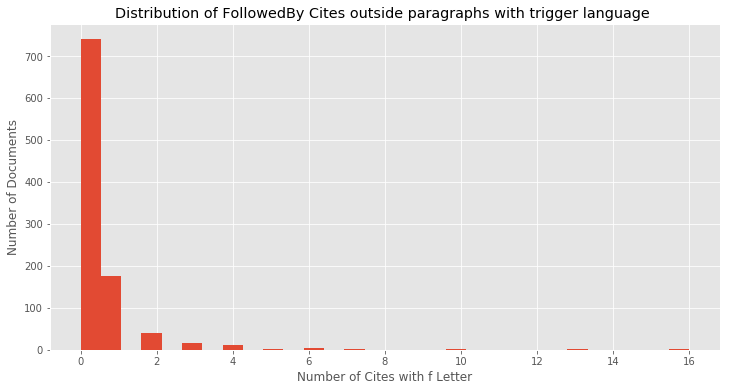

In [146]:
df_group = df.query('trgr_language == ""').groupby(['filename'])['cnt_f_letter_cite_in_para'].agg('sum').to_frame('cites_with_f_letter')
hist = df_group.hist(column="cites_with_f_letter", bins=30, figsize=(12,6))
hist[0][0].set_ylabel('Number of Documents')
hist[0][0].set_xlabel('Number of Cites with f Letter')
hist[0][0].set_title('Distribution of FollowedBy Cites outside paragraphs with trigger language ')

### Visualization of  cite infromation and trigger language embedded within a para 
Trigger language has reference to cites as shown in the xml below. 

<laaa:treatmentTriggerCiteReference ID="I5VW15DW2N1R7H0JK0000400"/>

Actual cite element (or anaphoric reference to cite) corresponding to ID may be in the same para as trigger language or it could be in another para.

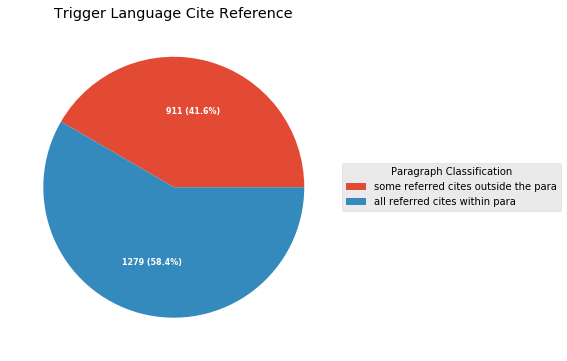

In [131]:
import matplotlib.pyplot as plt
import numpy as np

columns = ['cnt_cite_in_para', 'cnt_cite_referenced', 'cnt_cite_referenced_in_para', 'cnt_f_letter_cite_in_para', 'cnt_nonf_letter_cite_in_para']
df0 = df.groupby(['filename','para_id'])[columns[0]].agg('max').astype(float).to_frame(columns[0]).reset_index()
df1 = df.groupby(['filename','para_id'])[columns[1]].agg('sum').astype(float).to_frame(columns[1]).reset_index()
df2 = df.groupby(['filename','para_id'])[columns[2]].agg('sum').astype(float).to_frame(columns[2]).reset_index()
df3 = df.groupby(['filename','para_id'])[columns[3]].agg('sum').astype(float).to_frame(columns[3]).reset_index()
df4 = df.groupby(['filename','para_id'])[columns[4]].agg('sum').astype(float).to_frame(columns[4]).reset_index()
df_cite_counts = df0
df_cite_counts[columns[1]] = df1[columns[1]]
df_cite_counts[columns[2]] = df2[columns[2]]
df_cite_counts[columns[3]] = df3[columns[3]]
df_cite_counts[columns[4]] = df4[columns[4]]
cnt_partial_ref  = df_cite_counts.query('cnt_cite_referenced != 0 and cnt_cite_referenced != cnt_cite_referenced_in_para')
cnt_complete_ref = df_cite_counts.query('cnt_cite_referenced != 0 and cnt_cite_referenced == cnt_cite_referenced_in_para')

fig, ax = plt.subplots(figsize=(9, 6), subplot_kw=dict(aspect="equal"))

data = [len(cnt_partial_ref.index), len(cnt_complete_ref.index)]
lbls = ['some referred cites outside the para', 'all referred cites within para']

def func(percent, vals):
    absolute = int(percent/100.0 * np.sum(vals))
    return "{:d} ({:.1f}%) ".format(absolute, percent)


wedges, texts, autotexts = ax.pie(data, autopct=lambda pct: func(pct, data),
                                  textprops=dict(color="w"))

ax.legend(wedges, lbls,
          title="Paragraph Classification",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.setp(autotexts, size=8, weight="bold")

ax.set_title("Trigger Language Cite Reference")

plt.show()

### Sample Query for finding documents with trigger language and no f letter cites within para

In [147]:
df_group = df.query('trgr_language != ""').groupby(['filename'])['cnt_f_letter_cite_in_para'].agg('sum').to_frame('cites_with_f_letter')
df_group.query('cites_with_f_letter == 0').reset_index().head()

filename  cites_with_f_letter
0  BL01258142.XML                    0
1  BL01262550.XML                    0
2  BL01408914.XML                    0
3  BL01565589.XML                    0
4  BL01606670.XML                    0

### Export to csv

In [150]:
columns = ['filename', 
           'para_id', 
           'para_text', 
           'trgr_language', 
           'group_id', 
           'fragment_id', 
           'editor_id', 
           'cites_in_para',
           'cnt_cite_in_para', 
           'cnt_cite_in_para_anaphref', 
           'cnt_f_letter_cite_in_para', 
           'cnt_nonf_letter_cite_in_para',
           'cnt_cite_referenced',
           'cnt_cite_referenced_in_para']

df.to_csv(r'\\legal.regn.net\DAY\Shares\Themis\GoldenFTraining\Analysis\followedbytriggerlanguage.csv', columns=columns, index=False)